In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


Upload dos datasets de treino e de testes obtidos no **tarefa_2_get_data**:

In [2]:
data_treino = pd.read_csv('dataset_treino.csv', na_filter=False)
data_teste = pd.read_csv('dataset_teste.csv', na_filter=False)

Damos drop da coluna Data:

In [3]:
#data_treino.drop(columns=['Data'], inplace=True)
#data_teste.drop(columns=['Data'], inplace=True)

One hot encoding do atributo weather_description no dataset de treino e de teste:

In [4]:
lb = LabelBinarizer()
lb_results = lb.fit_transform(data_treino['weather_description'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

data_treino = pd.concat([data_treino, lb_results_df], axis=1)
data_treino.drop(columns=['weather_description'], inplace=True)
data_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Data                     11016 non-null  object 
 1   Ano_x                    11016 non-null  int64  
 2   Mês_x                    11016 non-null  int64  
 3   Dia_x                    11016 non-null  int64  
 4   Hora_x                   11016 non-null  int64  
 5   Normal (kWh)             11016 non-null  float64
 6   Horário Económico (kWh)  11016 non-null  float64
 7   Autoconsumo (kWh)        11016 non-null  float64
 8   Injeção na rede (kWh)    11016 non-null  object 
 9   Ano_y                    11016 non-null  int64  
 10  Mês_y                    11016 non-null  int64  
 11  Dia_y                    11016 non-null  int64  
 12  Hora_y                   11016 non-null  int64  
 13  feels_like               11016 non-null  float64
 14  temp_min              

In [5]:
lb = LabelBinarizer()
lb_results = lb.fit_transform(data_teste['weather_description'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

data_teste = pd.concat([data_teste, lb_results_df], axis=1)
data_teste.drop(columns=['weather_description'], inplace=True)


Feature Engineering: criamos os atributos pressure_level, rolling_avg_temp, temp_humidity_interaction e wind_rain_interaction:

In [6]:
data_treino['pressure_level'] = pd.cut(data_treino['pressure'], bins=[0, 1000, 1020, 1050], labels=['low', 'medium', 'high'])
data_teste['pressure_level'] = pd.cut(data_teste['pressure'], bins=[0, 1000, 1020, 1050], labels=['low', 'medium', 'high'])

data_treino['rolling_avg_temp'] = data_treino['temp_max'].rolling(window=3).mean()
data_teste['rolling_avg_temp'] = data_teste['temp_max'].rolling(window=3).mean()
data_treino['rolling_avg_temp'].fillna(data_treino['temp_max'], inplace=True)
data_teste['rolling_avg_temp'].fillna(data_teste['temp_max'], inplace=True)


data_treino['temp_humidity_interaction'] = data_treino['temp_max'] * data_treino['humidity']
data_teste['temp_humidity_interaction'] = data_teste['temp_max'] * data_teste['humidity']

data_treino['wind_rain_interaction'] = data_treino['wind_speed'] * data_treino['rain_1h']
data_teste['wind_rain_interaction'] = data_teste['wind_speed'] * data_teste['rain_1h']

data_treino['temp_wind_interaction'] = data_treino['temp_max'] * data_treino['wind_speed']
data_teste['temp_wind_interaction'] = data_teste['temp_max'] * data_teste['wind_speed']

data_treino['wind_humidity_interaction'] = data_treino['wind_speed'] * data_treino['humidity']
data_teste['wind_humidity_interaction'] = data_teste['wind_speed'] * data_teste['humidity']

data_treino['humidity_rain_interaction'] = data_treino['humidity'] * data_treino['rain_1h']
data_teste['humidity_rain_interaction'] = data_teste['humidity'] * data_teste['rain_1h']

data_treino['month_mean_consumption'] = data_treino.groupby('Mês_x')['Normal (kWh)'].transform('mean')
data_teste['month_mean_consumption'] = data_teste['Mês_x'].map(data_treino.groupby('Mês_x')['Normal (kWh)'].mean())


data_treino['daily_mean_consumption'] = data_treino.groupby('Data')['Normal (kWh)'].transform('mean')
data_teste['daily_mean_consumption'] = data_teste['Data'].map(data_treino.groupby('Data')['Normal (kWh)'].mean())


data_treino['relative_humidity'] = (data_treino['humidity'] / data_treino['humidity'].max()) * 100
data_teste['relative_humidity'] = (data_teste['humidity'] / data_teste['humidity'].max()) * 100

bins_wind = [0, 3, 5, 8, 11]
labels_wind = ['calm', 'light', 'moderate', 'strong']
data_treino['wind_speed_category'] = pd.cut(data_treino['wind_speed'], bins=bins_wind, labels=labels_wind)
data_teste['wind_speed_category'] = pd.cut(data_teste['wind_speed'], bins=bins_wind, labels=labels_wind)

#max_wind_speed = data_treino['wind_speed'].max()
#min_wind_speed = data_treino['wind_speed'].min()
#print(f"Maximum Wind Speed: {max_wind_speed}")
#print(f"Minimum Wind Speed: {min_wind_speed}")

#lag feature para analisarmos as defasagem da temp max
data_treino['lag_temp_max'] = data_treino['temp_max'].shift(1)
data_treino['lag_temp_max'].fillna(data_treino['temp_max'], inplace=True)
data_treino['temp_change'] = data_treino['temp_max'] - data_treino['lag_temp_max']

data_teste['lag_temp_max'] = data_teste['temp_max'].shift(1)
data_teste['lag_temp_max'].fillna(data_teste['temp_max'], inplace=True)
data_teste['temp_change'] = data_teste['temp_max'] - data_teste['lag_temp_max']

data_treino['temp_deviation_from_month_mean'] = data_treino['temp_max'] - data_treino.groupby('Mês_y')['temp_max'].transform('mean')
data_teste['temp_deviation_from_month_mean'] = data_teste['temp_max'] - data_teste['Mês_y'].map(data_treino.groupby('Mês_y')['temp_max'].mean())

data_treino['wind_speed_deviation_from_daily_mean'] = data_treino['wind_speed'] - data_treino.groupby('Data')['wind_speed'].transform('mean')
data_teste['wind_speed_deviation_from_daily_mean'] = data_teste['wind_speed'] - data_teste['Data'].map(data_treino.groupby('Data')['wind_speed'].mean())

data_treino['humidity_deviation_from_month_mean'] = data_treino['humidity'] - data_treino.groupby('Mês_y')['humidity'].transform('mean')
data_teste['humidity_deviation_from_month_mean'] = data_teste['humidity'] - data_teste['Mês_y'].map(data_treino.groupby('Mês_y')['humidity'].mean())

data_treino['rolling_avg_temp_humidity_interaction'] = data_treino['rolling_avg_temp'] * data_treino['humidity']
data_teste['rolling_avg_temp_humidity_interaction'] = data_teste['rolling_avg_temp'] * data_teste['humidity']

data_treino['wind_humidity_rain_interaction'] = data_treino['wind_speed'] * data_treino['humidity'] * data_treino['rain_1h']
data_teste['wind_humidity_rain_interaction'] = data_teste['wind_speed'] * data_teste['humidity'] * data_teste['rain_1h']

data_treino.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11016 entries, 0 to 11015
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   Data                                   11016 non-null  object  
 1   Ano_x                                  11016 non-null  int64   
 2   Mês_x                                  11016 non-null  int64   
 3   Dia_x                                  11016 non-null  int64   
 4   Hora_x                                 11016 non-null  int64   
 5   Normal (kWh)                           11016 non-null  float64 
 6   Horário Económico (kWh)                11016 non-null  float64 
 7   Autoconsumo (kWh)                      11016 non-null  float64 
 8   Injeção na rede (kWh)                  11016 non-null  object  
 9   Ano_y                                  11016 non-null  int64   
 10  Mês_y                                  11016 non-null  int

In [7]:
data_treino.drop(columns=['Data'], inplace=True)
data_teste.drop(columns=['Data'], inplace=True)

one-hot encoding do pressure_level:

In [8]:

pressure_level_dummies_train = pd.get_dummies(data_treino['pressure_level'], prefix='pressure_')

data_treino = pd.concat([data_treino, pressure_level_dummies_train], axis=1)

data_treino = data_treino.drop('pressure_level', axis=1)




wind_speed_category_dummies_train = pd.get_dummies(data_treino['wind_speed_category'], prefix='wind_speed_')

data_treino = pd.concat([data_treino, wind_speed_category_dummies_train], axis=1)

data_treino = data_treino.drop('wind_speed_category', axis=1)


In [9]:

pressure_level_dummies_test = pd.get_dummies(data_teste['pressure_level'], prefix='pressure_')

data_teste = pd.concat([data_teste, pressure_level_dummies_test], axis=1)

data_teste = data_teste.drop('pressure_level', axis=1)

wind_speed_category_dummies_test = pd.get_dummies(data_teste['wind_speed_category'], prefix='wind_speed_')

data_teste = pd.concat([data_teste, wind_speed_category_dummies_test], axis=1)

data_teste = data_teste.drop('wind_speed_category', axis=1)


In [10]:
float_features = data_treino.select_dtypes(include='float')
int_features = data_treino.select_dtypes(include='int')

data_treino[float_features.columns] = data_treino[float_features.columns].astype(np.float32)
data_treino[int_features.columns] = data_treino[int_features.columns].astype(np.int32)
#data_treino.info()

In [11]:
float_features = data_teste.select_dtypes(include='float')
int_features = data_teste.select_dtypes(include='int')

data_teste[float_features.columns] = data_teste[float_features.columns].astype(np.float32)
data_teste[int_features.columns] = data_teste[int_features.columns].astype(np.int32)
#data_teste.info()

In [12]:
data_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 50 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Ano_x                                  2256 non-null   int32  
 1   Mês_x                                  2256 non-null   int32  
 2   Dia_x                                  2256 non-null   int32  
 3   Hora_x                                 2256 non-null   int32  
 4   Normal (kWh)                           2256 non-null   float32
 5   Horário Económico (kWh)                2256 non-null   float32
 6   Autoconsumo (kWh)                      2256 non-null   float32
 7   Ano_y                                  2256 non-null   int32  
 8   Mês_y                                  2256 non-null   int32  
 9   Dia_y                                  2256 non-null   int32  
 10  Hora_y                                 2256 non-null   int32  
 11  feel

In [13]:
from sklearn.preprocessing import MinMaxScaler
data_treino_normalize = data_treino.copy()
data_teste_normalize = data_teste.copy()

X_scale = data_treino_normalize.drop(columns=['Injeção na rede (kWh)'])

scaler_X = MinMaxScaler(feature_range=(0,1)).fit(X_scale)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(data_teste_normalize)
X_scale = pd.DataFrame(scaler_X.transform(X_scale[X_scale.columns]), columns=X_scale.columns)
data_teste_normalize = pd.DataFrame(scaler_y.transform(data_teste_normalize[data_teste_normalize.columns]), columns=data_teste_normalize.columns)

data_treino_normalize = pd.concat([X_scale, data_treino_normalize['Injeção na rede (kWh)']], axis=1)

#data_treino_normalize.head()

c:\Users\migue\miniconda3\envs\daa\lib\site-packages\sklearn\preprocessing\_data.py:479: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
c:\Users\migue\miniconda3\envs\daa\lib\site-packages\sklearn\preprocessing\_data.py:480: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [14]:
float_features_normalize = data_treino_normalize.select_dtypes(include='float')

data_treino_normalize[float_features_normalize.columns] = data_treino_normalize[float_features_normalize.columns].astype(np.float32)
#data_treino_normalize.info()

In [15]:
float_features_normalize = data_teste_normalize.select_dtypes(include='float')

data_teste_normalize[float_features_normalize.columns] = data_teste_normalize[float_features_normalize.columns].astype(np.float32)
#data_teste_normalize.info()

In [16]:
data_treino.columns

Index(['Ano_x', 'Mês_x', 'Dia_x', 'Hora_x', 'Normal (kWh)',
       'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'Injeção na rede (kWh)',
       'Ano_y', 'Mês_y', 'Dia_y', 'Hora_y', 'feels_like', 'temp_min',
       'temp_max', 'pressure', 'humidity', 'wind_speed', 'rain_1h',
       'clouds_all', 'broken clouds', 'few clouds', 'heavy intensity rain',
       'light rain', 'moderate rain', 'overcast clouds', 'scattered clouds',
       'sky is clear', 'rolling_avg_temp', 'temp_humidity_interaction',
       'wind_rain_interaction', 'temp_wind_interaction',
       'wind_humidity_interaction', 'humidity_rain_interaction',
       'month_mean_consumption', 'daily_mean_consumption', 'relative_humidity',
       'lag_temp_max', 'temp_change', 'temp_deviation_from_month_mean',
       'wind_speed_deviation_from_daily_mean',
       'humidity_deviation_from_month_mean',
       'rolling_avg_temp_humidity_interaction',
       'wind_humidity_rain_interaction', 'pressure__low', 'pressure__medium',
     

In [17]:
data_treino.drop(columns=['Ano_y', 'Mês_y', 'Dia_y', 'Hora_y'], inplace=True)
data_teste.drop(columns=['Ano_y', 'Mês_y', 'Dia_y', 'Hora_y'], inplace=True)

data_treino_normalize.drop(columns=['Ano_y', 'Mês_y', 'Dia_y', 'Hora_y'], inplace=True)
data_teste_normalize.drop(columns=['Ano_y', 'Mês_y', 'Dia_y', 'Hora_y'], inplace=True)

In [18]:
data_treino.columns

Index(['Ano_x', 'Mês_x', 'Dia_x', 'Hora_x', 'Normal (kWh)',
       'Horário Económico (kWh)', 'Autoconsumo (kWh)', 'Injeção na rede (kWh)',
       'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'clouds_all', 'broken clouds', 'few clouds',
       'heavy intensity rain', 'light rain', 'moderate rain',
       'overcast clouds', 'scattered clouds', 'sky is clear',
       'rolling_avg_temp', 'temp_humidity_interaction',
       'wind_rain_interaction', 'temp_wind_interaction',
       'wind_humidity_interaction', 'humidity_rain_interaction',
       'month_mean_consumption', 'daily_mean_consumption', 'relative_humidity',
       'lag_temp_max', 'temp_change', 'temp_deviation_from_month_mean',
       'wind_speed_deviation_from_daily_mean',
       'humidity_deviation_from_month_mean',
       'rolling_avg_temp_humidity_interaction',
       'wind_humidity_rain_interaction', 'pressure__low', 'pressure__medium',
       'pressure__high', 'wind_speed__calm

In [19]:
X_treino = data_treino.drop(columns=['Injeção na rede (kWh)'])
y_treino = data_treino['Injeção na rede (kWh)']

X_teste = data_teste


X_treino_normalize = data_treino_normalize.drop(columns=['Injeção na rede (kWh)'])
y_treino_normalize = data_treino_normalize['Injeção na rede (kWh)']

X_teste_normalize = data_teste_normalize

In [20]:

X_train, X_test, y_train, y_test = train_test_split(X_treino, y_treino, test_size=0.25, random_state=2023, stratify=y_treino)
X_train_normalize, X_test_normalize, y_train_normalize, y_test_normalize = train_test_split(X_treino_normalize, y_treino_normalize, test_size=0.25, random_state=2023, stratify=y_treino_normalize)

In [21]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


xgb = XGBClassifier(random_state=2023, objective='multi:softprob', num_class=5)

# label_encoder = LabelEncoder()
# y_train_normalize = label_encoder.fit_transform(y_train_normalize)
# y_test_normalize = label_encoder.fit_transform(y_test_normalize)

label_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
y_train_normalize = y_train_normalize.replace(label_mapping)
y_test_normalize = y_test_normalize.replace(label_mapping)

Usamos Random Search:

c:\Users\migue\miniconda3\envs\daa\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=600;, score=0.877 total time=   1.8s
[CV 2/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=600;, score=0.883 total time=   1.7s
[CV 3/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=600;, score=0.878 total time=   1.7s
[CV 4/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=600;, score=0.890 total time=   1.7s
[CV 5/5] END colsample_bytree=0.8, gamma=0.1, learning_rate=0.01, max_depth=5, min_child_weight=2, n_estimators=600;, score=0.872 total time=   1.8s
Best Hyperparameters: {'n_estimators': 600, 'min_child_weight': 2, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
              precision    recall  f1-score   suppo

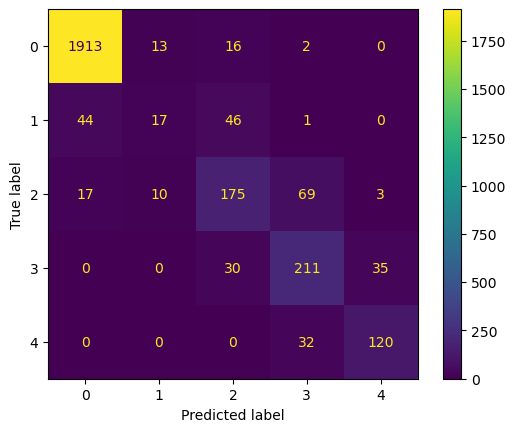

In [22]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


# Define the parameter grid
param_dist = {
    'learning_rate': [0.01],
    'n_estimators': [600],
    'max_depth': [5],
    'gamma': [0.1],
    'min_child_weight': [2],
    'colsample_bytree': [0.8],
}

# Use RandomizedSearchCV instead of GridSearchCV
random_searchXGB = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations based on your resources
    scoring=make_scorer(accuracy_score),  # Change this to your desired metric
    cv=5,
    refit=True,
    verbose=3,
    random_state=2023
)

# Fit the model
random_searchXGB.fit(X_train_normalize, y_train_normalize)


# Get the best estimator and its hyperparameters
XGB_best  = random_searchXGB.best_estimator_
best_params = random_searchXGB.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predictions and evaluation
grid_predictionXGB = random_searchXGB.predict(X_test_normalize)
print(classification_report(y_test_normalize, grid_predictionXGB))
ConfusionMatrixDisplay.from_estimator(XGB_best, X_test_normalize, y_test_normalize)
plt.show()

In [23]:
# label_encoder = LabelEncoder()
# y_treino_normalize = label_encoder.fit_transform(y_treino_normalize)

label_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
y_treino_normalize = y_treino_normalize.replace(label_mapping)

XGB_best.fit(X_treino_normalize, y_treino_normalize)
predictionXGB = XGB_best.predict(X_teste_normalize)

inverted_label_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
predictionXGB = np.vectorize(inverted_label_mapping.get)(predictionXGB)

# predictionXGB = label_encoder.inverse_transform(predictionXGB)

In [ ]:
with open('results.csv', 'w') as results:
    results.write('RowId,Result\n')
    i = 1
    for p in predictionXGB:
        results.write(f'{i},{p}\n')
        i+=1